### DSC 680 Week  : 
#### Project 3 ChatBot
#### Author: Brian Reppeto 2/23/2025

### Import Libraries

In [1]:
import os
import torch
from sklearn.model_selection import train_test_split
from transformers import BlenderbotTokenizer, BlenderbotForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset
from transformers import TrainerCallback


### Clear any cached GPU memory

In [2]:
# clear any cached GPU memory
torch.cuda.empty_cache()

### Check GPU Availability

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Load & Preprocess the Cornell Movie Dialogs Dataset:  Read movie lines and conversation data from two text files and link them using unique identifiers to create dialogue pairs. Then filters out empty or invalid pairs to produce a clean dataset of conversational exchanges.

In [4]:
data_path = r"C:\Users\brepp\BER Data Science\DSC680\Final_project"
output_dir = r"C:\Users\brepp\BER Data Science\DSC680\Final_project"

# load movie_lines.txt
lines_file = os.path.join(data_path, "movie_lines.txt")
id_to_line = {}
with open(lines_file, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        parts = line.strip().split(" +++$+++ ")
        if len(parts) > 4:
            line_id = parts[0]
            dialogue = parts[4]
            id_to_line[line_id] = dialogue

# load movie_conversations.txt
conv_file = os.path.join(data_path, "movie_conversations.txt")
dialog_pairs = []
with open(conv_file, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        parts = line.strip().split(" +++$+++ ")
        if len(parts) > 3:
            utterance_ids = eval(parts[3])
            for i in range(len(utterance_ids) - 1):
                q_id = utterance_ids[i]
                a_id = utterance_ids[i + 1]
                if q_id in id_to_line and a_id in id_to_line:
                    dialog_pairs.append({"input_text": id_to_line[q_id], "output_text": id_to_line[a_id]})

# filter out empty or whitespace dialogues
dialog_pairs = [
    {"input_text": q, "output_text": a}
    for q, a in ((pair["input_text"], pair["output_text"]) for pair in dialog_pairs)
    if q.strip() and a.strip()
]
print(f"Cleaned dataset. Remaining conversations: {len(dialog_pairs)}")


Cleaned dataset. Remaining conversations: 221282


### Split the Data into Train & Evaluation Sets

In [5]:
train_pairs, eval_pairs = train_test_split(dialog_pairs, test_size=0.2, random_state=42)

### Load the Model and Tokenizer

In [6]:
model_name = "facebook/blenderbot-90M"
from transformers import BlenderbotSmallTokenizer, BlenderbotSmallForConditionalGeneration
tokenizer = BlenderbotSmallTokenizer.from_pretrained(model_name)
model = BlenderbotSmallForConditionalGeneration.from_pretrained(model_name)

### Create a Custom PyTorch Dataset:  Create a custom dataset class for movie dialogues. The class takes in dialogue pairs and a tokenizer, and for each dialogue, it tokenizes the input and output texts (ensuring they have a fixed maximum length and proper padding), returning a dictionary with input IDs, attention masks, and label IDs. 

In [7]:
class MovieDialogDataset(Dataset):
    def __init__(self, dialog_pairs, tokenizer, max_length=128):
        self.dialog_pairs = dialog_pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dialog_pairs)

    def __getitem__(self, idx):
        dialog = self.dialog_pairs[idx]
        input_text = dialog["input_text"]
        output_text = dialog["output_text"]

        # tokenize input and output
        input_enc = self.tokenizer(
            input_text if input_text else "",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        output_enc = self.tokenizer(
            output_text if output_text else "",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": output_enc["input_ids"].squeeze()
        }

# create objects for training and evaluation
train_dataset = MovieDialogDataset(train_pairs, tokenizer)
eval_dataset = MovieDialogDataset(eval_pairs, tokenizer)
print(f"Train Size: {len(train_dataset)} | Eval Size: {len(eval_dataset)}")

Train Size: 177025 | Eval Size: 44257


### Set Up Training with GPU:   Enable gradient for memory efficiency. Move the model to the GPU, and set up training configurations for batch size, evaluation, logging. Initialize a trainer for the loop and clear the GPU cache to free up unused memory.

In [8]:
model.gradient_checkpointing_enable()  # enable gradient checkpointing to save memory
model.to(device)

training_args = TrainingArguments(
    output_dir="./blenderbot-movie-finetuned",
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    per_device_train_batch_size=32,    
    per_device_eval_batch_size=32,     
    gradient_accumulation_steps=1,       
    dataloader_num_workers=0,            
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

torch.cuda.empty_cache()

C:\Users\brepp\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Start Fine-Tuning and Save the Model

In [9]:
# start Fine-Tuning
trainer.train()
trainer.save_model()  
tokenizer.save_pretrained(training_args.output_dir)

Step,Training Loss,Validation Loss
500,0.436600,0.430547
1000,0.438900,0.422737
1500,0.426000,0.418298
2000,0.421700,0.415568
2500,0.428100,0.412704
3000,0.426800,0.410760
3500,0.432800,0.408840
4000,0.418400,0.407154
4500,0.428700,0.405541
5000,0.402100,0.404537


C:\Users\brepp\AppData\Roaming\Python\Python312\site-packages\transformers\modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 20, 'num_beams': 10, 'length_penalty': 0.65, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('./blenderbot-movie-finetuned\\tokenizer_config.json',
 './blenderbot-movie-finetuned\\special_tokens_map.json',
 './blenderbot-movie-finetuned\\vocab.json',
 './blenderbot-movie-finetuned\\merges.txt',
 './blenderbot-movie-finetuned\\added_tokens.json')

### Chat Interface:  Load the Blenderbot Small model and tokenizer, set up a function to generate short, responses from user input, and run an interactive chatbot loop until the user quits.

In [50]:
import torch
from transformers import BlenderbotSmallTokenizer, BlenderbotSmallForConditionalGeneration

# path to your fine-tuned model directory
model_dir = r"C:\Users\brepp\BER Data Science\DSC680\Final_project\blenderbot-movie-finetuned"

# check if GPU is available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the tokenizer and blenderbot
tokenizer = BlenderbotSmallTokenizer.from_pretrained(model_dir)
model = BlenderbotSmallForConditionalGeneration.from_pretrained(model_dir)
model.to(device)

def get_concise_response(user_input):
    # tokenize the input text and move tensors to the correct device
    inputs = tokenizer([user_input], return_tensors='pt').to(device)
    
    # generate a response with parameters tuned for conciseness:
    reply_ids = model.generate(
        **inputs,
        max_new_tokens=20,      # limit response length 
        early_stopping=True,
        do_sample=False        
    )
    
    # decode tokens to a string
    response = tokenizer.batch_decode(reply_ids, skip_special_tokens=True)[0].strip()
    
    
    if not response.endswith((".", "!", "?")):
        response += "."
    
    return response

# conversation loop
print("Chatbot is ready! Type 'exit' or 'quit' to stop the conversation.")
while True:
    user_input = input("User: ")
    if user_input.lower() in ["exit","stop","bye", "quit"]:
        print("Chatbot: Goodbye!")
        break
    response = get_concise_response(user_input)
    print("Chatbot:", response)


Chatbot is ready! Type 'exit' or 'quit' to stop the conversation.


User:  Do you know who Yoda is


Chatbot: of course i know who yoda is . he ' s a jedi master .


User:  Do you know who Darth Vader is 


Chatbot: of course i know who darth vader is . he ' s a jedi master .


User:  Who is luke skywalkers father


Chatbot: i don ' t know . he ' s a friend of my father ' s .


User:  Does Yoda die


Chatbot: i don ' t think so . . . i think he ' s dead .


User:  Does luke skywalker die


Chatbot: i don ' t think so . i think he ' s going to die .


User:  what is a jedi master


Chatbot: a jedi master is a master of the dark side of the force . . .


User:  who are all of the jedi masters


Chatbot: jedi masters ? i don ' t know . they ' re all the same .


User:  What movies do you know


Chatbot: i know a lot of movies . i ' ve seen all of them . i don ' t.


User:  which movie is your favorite


Chatbot: i don ' t know . it ' s hard to say . i ' ve never seen it.


User:  Which genere of movies do you like


Chatbot: i don ' t know . . . i ' ve never really been into movies .


User:  Which movie is the longest


Chatbot: i don ' t know . i ' ve never seen a movie that ' s that long .


User:  bye


Chatbot: Goodbye!


### Plot Training data

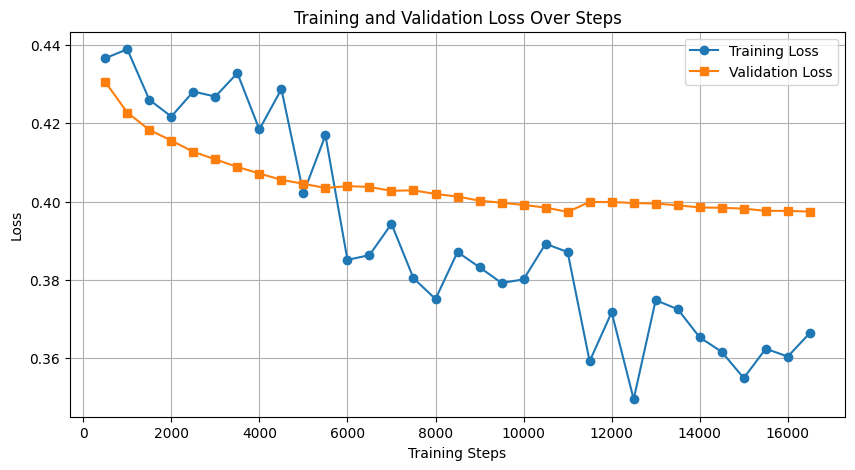

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# dataset 
data = {
    "Step": [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000,
              5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000,
              10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000,
              15500, 16000, 16500],
    "Training Loss": [
        0.436600, 0.438900, 0.426000, 0.421700, 0.428100, 0.426800, 0.432800, 0.418400, 0.428700, 0.402100,
        0.416900, 0.385100, 0.386300, 0.394300, 0.380400, 0.375100, 0.387100, 0.383200, 0.379200, 0.380100,
        0.389200, 0.387100, 0.359200, 0.371700, 0.349500, 0.374800, 0.372500, 0.365300, 0.361600, 0.354900,
        0.362400, 0.360400, 0.366400
    ],
    "Validation Loss": [
        0.430547, 0.422737, 0.418298, 0.415568, 0.412704, 0.410760, 0.408840, 0.407154, 0.405541, 0.404537,
        0.403450, 0.403937, 0.403719, 0.402722, 0.402868, 0.401919, 0.401273, 0.400206, 0.399704, 0.399120,
        0.398463, 0.397345, 0.399888, 0.399865, 0.399624, 0.399479, 0.399039, 0.398479, 0.398401, 0.398176,
        0.397624, 0.397604, 0.397428
    ]
}

df = pd.DataFrame(data)

# training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(df["Step"], df["Training Loss"], label="Training Loss", marker='o')
plt.plot(df["Step"], df["Validation Loss"], label="Validation Loss", marker='s')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Steps")
plt.legend()
plt.grid()
plt.show()


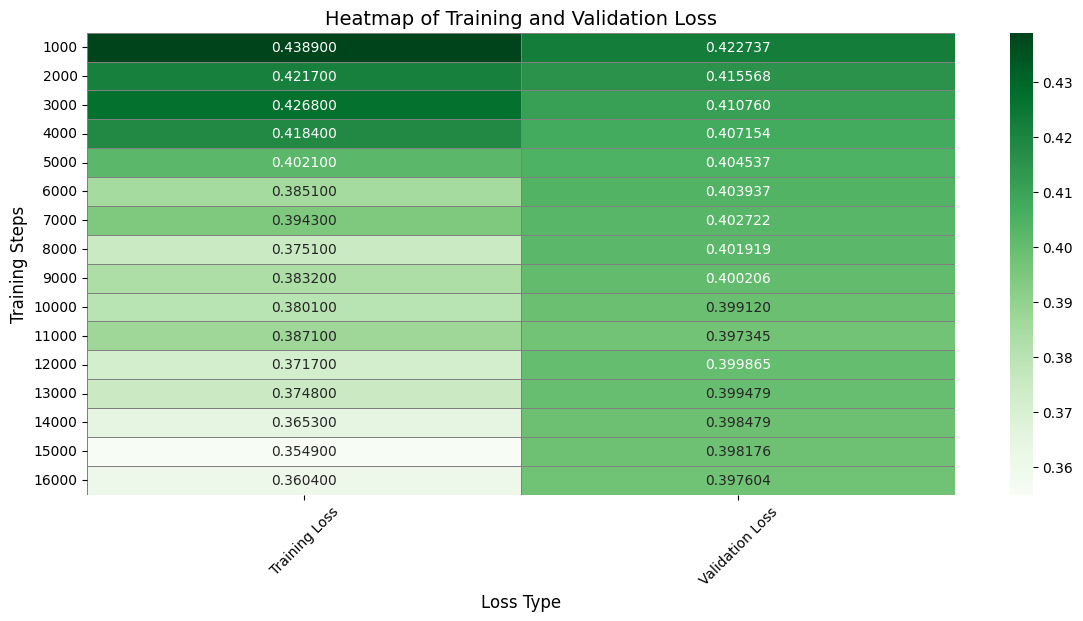

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


thous = {
    "Step": [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000,
              11000, 12000, 13000, 14000, 15000, 16000],
    "Training Loss": [
        0.438900, 0.421700, 0.426800, 0.418400, 0.402100,
        0.385100, 0.394300, 0.375100, 0.383200, 0.380100,
        0.387100, 0.371700, 0.374800, 0.365300, 0.354900,
        0.360400
    ],
    "Validation Loss": [
        0.422737, 0.415568, 0.410760, 0.407154, 0.404537,
        0.403937, 0.402722, 0.401919, 0.400206, 0.399120,
        0.397345, 0.399865, 0.399479, 0.398479, 0.398176,
        0.397604
    ]
}

dataf = pd.DataFrame(thous)

# heatmap 
df_heatmap = dataf.set_index("Step")
plt.figure(figsize=(14, 6))
sns.heatmap(df_heatmap, annot=True, cmap="Greens", fmt=".6f", linewidths=0.5, linecolor='gray', 
            cbar=True, square=False)
plt.title("Heatmap of Training and Validation Loss", fontsize=14)
plt.xlabel("Loss Type", fontsize=12)
plt.ylabel("Training Steps", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
